In [ ]:
!pip install evaluate bert-score datasets transformers torch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset, Dataset
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import json
from pathlib import Path

import torch
from tqdm import tqdm
from transformers import TrainingArguments, Trainer
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, AutoModel
import evaluate

In [ ]:
# mount drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_train_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/X_train.csv"
X_val_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/X_val.csv"
# X_test_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/X_test.csv"
X_test_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/X_test_clean.csv"
y_train_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/y_train.csv"
y_val_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/y_val.csv"
y_test_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/y_test_clean.csv"


X_train = pd.read_csv(X_train_path, encoding='latin1', on_bad_lines='skip')
X_val = pd.read_csv(X_val_path, encoding='latin1', on_bad_lines='skip')
X_test = pd.read_csv(X_test_path, encoding='latin1', on_bad_lines='skip')
y_train = pd.read_csv(y_train_path, encoding='latin1', on_bad_lines='skip')
y_val = pd.read_csv(y_val_path, encoding='latin1', on_bad_lines='skip')
y_test = pd.read_csv(y_test_path, encoding='latin1', on_bad_lines='skip')

print(f"Training set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")
print(f"Testing set size: {len(X_test)} samples")
print(f"Training labels size: {len(y_train)} samples")
print(f"Validation labels size: {len(y_val)} samples")
print(f"Testing labels size: {len(y_test)} samples")

Training set size: 8000 samples
Validation set size: 1000 samples
Testing set size: 982 samples
Training labels size: 8000 samples
Validation labels size: 1000 samples
Testing labels size: 983 samples


In [ ]:
model_name = "google/electra-base-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def preprocess_dataset(data, tokenizer, summary_column="summary"):
  """
  Tokenizes the document and summary pairs using the provided tokenizer.
  """
  # Combine document and summary into a list of text pairs for batched tokenization
  text_pairs = list(zip(data["document"], data[summary_column]))

  encoded_inputs = tokenizer(
      text_pairs, # Pass the list of (document, summary) tuples
      max_length=MAX_LENGTH,
      padding="max_length",
      truncation=True,
      return_tensors="pt" # Return PyTorch tensors
  )

  # For a sequence classification task, we also need to include the labels.
  # Assuming 'label_binary' is the column containing the classification labels (0 or 1).
  # Convert the label to a PyTorch tensor and ensure it's a long type for classification loss functions.
  encoded_inputs["labels"] = torch.tensor(data['label_binary'], dtype=torch.long)

  return encoded_inputs

In [ ]:
metric = evaluate.load('accuracy')


def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Unwrap tuple if needed
    if isinstance(logits, (tuple, list)):
        logits = logits[0]

    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels)

In [ ]:
def fine_tune_electra_model(
    model,
    tokenizer,
    train_data_X, # This is X_train DataFrame
    train_data_y, # This is y_train Series
    val_data_X,   # This is X_val DataFrame
    val_data_y,   # This is y_val Series
    batch_size = 16,
    num_epochs = 2,
    fp16 = False
):
  """
  Preprocesses data using the selected tokenizer and fine-tunes a pre-trained model.
  """
  # Combine X and y into a single DataFrame for the Dataset conversion
  train_df = train_data_X.copy()
  train_df['label_binary'] = train_data_y

  val_df = val_data_X.copy()
  val_df['label_binary'] = val_data_y

  # Convert pandas DataFrames to datasets.Dataset objects
  train_dataset = Dataset.from_pandas(train_df)
  val_dataset = Dataset.from_pandas(val_df)

  preprocessed_train_data = train_dataset.map(preprocess_dataset, batched=True, fn_kwargs={'tokenizer': tokenizer})
  preprocessed_val_data = val_dataset.map(preprocess_dataset, batched=True, fn_kwargs={'tokenizer': tokenizer})

  training_args = TrainingArguments(
      output_dir="/content/drive/MyDrive/NLP/LLM_Hallucination/electra_hallucinations",
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=num_epochs,
      eval_strategy="epoch",
      save_strategy="epoch",
      fp16=fp16,
      report_to="none"
  )

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=preprocessed_train_data,
      eval_dataset=preprocessed_val_data,
      compute_metrics=compute_metrics
  )

  trainer.train()

In [ ]:
MAX_LENGTH = 512

In [ ]:
fine_tune_electra_model(model, tokenizer, X_train, y_train, X_val, y_val, batch_size=8, fp16=True)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.287300,0.294898,0.925000
2,0.132500,0.149892,0.967000


In [ ]:
# reload fine-tuned model
model_path = "/content/drive/MyDrive/NLP/LLM_Hallucination/electra_hallucinations/checkpoint-1000"
model = AutoModelForSequenceClassification.from_pretrained(model_path)

## Results

In [ ]:
# Prepare the test dataset
test_df = X_test.copy()
test_df['label_binary'] = y_test
test_dataset = Dataset.from_pandas(test_df)
preprocessed_test_data = test_dataset.map(preprocess_dataset, batched=True, fn_kwargs={'tokenizer': tokenizer})

# Re-instantiate TrainingArguments for evaluation (output_dir is needed)
eval_args = TrainingArguments(
    output_dir="t5_electra_eval", # A different directory for eval outputs if desired
    per_device_eval_batch_size=16,
    report_to="none"
)

# Instantiate a Trainer with the fine-tuned model for prediction
eval_trainer = Trainer(
    model=model,
    args=eval_args
)

# Get predictions on the test set
predictions_output = eval_trainer.predict(preprocessed_test_data)

# Extract predicted logits and true labels
predictions_logits = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert logits to predicted labels (0 or 1)
predicted_labels = np.argmax(predictions_logits, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='binary')
recall = recall_score(true_labels, predicted_labels, average='binary')
f1 = f1_score(true_labels, predicted_labels, average='binary')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Optionally, print a full classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Map:   0%|          | 0/982 [00:00<?, ? examples/s]

Test Accuracy: 0.9053
Test Precision: 0.8645
Test Recall: 0.9613
Test F1-Score: 0.9103

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       491
           1       0.86      0.96      0.91       491

    accuracy                           0.91       982
   macro avg       0.91      0.91      0.90       982
weighted avg       0.91      0.91      0.90       982



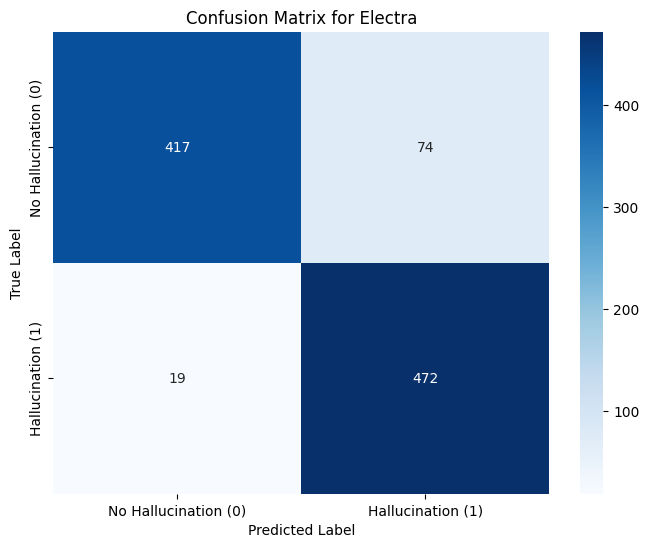

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels for better readability
class_labels = ['No Hallucination (0)', 'Hallucination (1)']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Electra')
plt.show()

In [ ]:
def compute_ece(y_prob, y_true, n_bins=20):
    """
    y_prob: numpy array of predicted probabilities for the positive class, shape [N]
    y_true: numpy array of true labels (0 or 1), shape [N]
    n_bins: number of confidence bins
    """
    y_prob = np.asarray(y_prob)
    y_true = np.asarray(y_true)

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    N = y_true.shape[0]

    for i in range(n_bins):
        start = bin_edges[i]
        end = bin_edges[i + 1]

        if i == 0:
            in_bin = (y_prob >= start) & (y_prob <= end)
        else:
            in_bin = (y_prob > start) & (y_prob <= end)

        bin_count = np.sum(in_bin)
        if bin_count == 0:
            continue

        bin_probs = y_prob[in_bin]
        bin_labels = y_true[in_bin]

        # Empirical positive rate in this bin
        bin_acc = bin_labels.mean()          # fraction of y=1
        bin_conf = bin_probs.mean()          # average predicted P(y=1)

        ece += (bin_count / N) * abs(bin_acc - bin_conf)

    return ece

In [ ]:
logits = torch.tensor(predictions_logits)

if logits.shape[1] == 1:
  # Binary classifier for single logit
  y_prob = torch.sigmoid(logits).squeeze(1).numpy()
else:
  # Use softmax to get probability of class 1
  y_prob = torch.softmax(logits, dim=-1)[:, 1].numpy()

ece = compute_ece(y_prob, true_labels)
print("Test set ECE:")
print(f"ECE: {ece:.4f}")

Test set ECE:
ECE: 0.0835


In [ ]:
para_test_df = X_test.copy()
para_test_df['label_binary'] = y_test
para_test_dataset = Dataset.from_pandas(para_test_df)
preprocessed_test_data_para = test_dataset.map(
    preprocess_dataset,
    batched=True,
    fn_kwargs={"tokenizer": tokenizer, "summary_column": "summary_paraphrased"},
)

# Re-instantiate TrainingArguments for evaluation (output_dir is needed)
eval_args = TrainingArguments(
    output_dir="deberta_hallucinations_eval", # A different directory for eval outputs if desired
    per_device_eval_batch_size=16,
    report_to="none"
)

# Instantiate a Trainer with the fine-tuned model for prediction
eval_trainer = Trainer(
    model=model,
    args=eval_args
)

# Get predictions on the test set
predictions_output = eval_trainer.predict(preprocessed_test_data_para)

# Extract predicted logits and true labels
predictions_logits = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert logits to predicted labels (0 or 1)
predicted_labels = np.argmax(predictions_logits, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='binary')
recall = recall_score(true_labels, predicted_labels, average='binary')
f1 = f1_score(true_labels, predicted_labels, average='binary')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Optionally, print a full classification report
print("\nClassification Report For Paraphrased Test Set:")
print(classification_report(true_labels, predicted_labels))

Map:   0%|          | 0/982 [00:00<?, ? examples/s]

Test Accuracy: 0.7444
Test Precision: 0.6690
Test Recall: 0.9674
Test F1-Score: 0.7910

Classification Report For Paraphrased Test Set:
              precision    recall  f1-score   support

           0       0.94      0.52      0.67       491
           1       0.67      0.97      0.79       491

    accuracy                           0.74       982
   macro avg       0.81      0.74      0.73       982
weighted avg       0.81      0.74      0.73       982



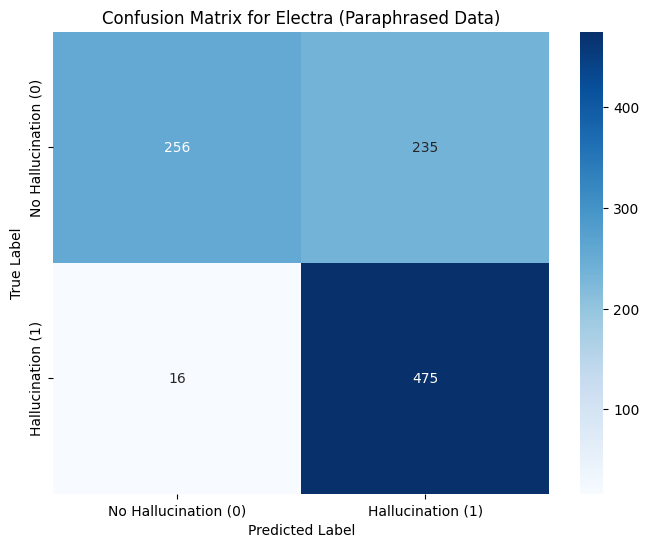

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels for better readability
class_labels = ['No Hallucination (0)', 'Hallucination (1)']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Electra (Paraphrased Data)')
plt.show()

In [ ]:
logits = torch.tensor(predictions_logits)

if logits.shape[1] == 1:
  # Binary classifier for single logit
  y_prob = torch.sigmoid(logits).squeeze(1).numpy()
else:
  # Use softmax to get probability of class 1
  y_prob = torch.softmax(logits, dim=-1)[:, 1].numpy()

ece = compute_ece(y_prob, true_labels, n_bins=20)
print("Paraphrased test set ECE:")
print(f"ECE: {ece:.4f}")

Paraphrased test set ECE:
ECE: 0.2415
